# Description

* Quality control on MiSeq run data
  * post-merging
  * post-demultiplexing

# Setting variables

In [4]:
import os

baseDir = '/home/sam/notebooks/hemp_microbiome/data/16S_OTUs/'
workDir = os.path.join(baseDir, 'QC')
seqFile = os.path.join(baseDir, 'pear_merged-2018-03-30.assembled.dmult.fastq')

# number of processors
nprocs = 24

# max expected error
maxee = 1

# Init

In [5]:
import re
import pandas as pd

In [6]:
%load_ext rpy2.ipython
#%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [7]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:dplyr’:

    combine


  warnings.warn(x, RRuntimeWarning)


In [8]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir

/home/sam/notebooks/hemp_microbiome/data/16S_OTUs/QC


In [9]:
# symlinking demult seq file into CQ
tmp = os.path.join(baseDir, seqFile)
if not os.path.isfile(seqFile):
    tmp2 = os.path.split(tmp)[1]
    os.symlink(tmp, tmp2)
else:
    print ('File exists: {}'.format(os.path.join(workDir, seqFile)))

File exists: /home/sam/notebooks/hemp_microbiome/data/16S_OTUs/pear_merged-2018-03-30.assembled.dmult.fastq


# Merged read quality filtering

## Discard sequences that exceed max expected error theshold

In [10]:
qcFile = os.path.split(seqFile)[1]
qcFile = os.path.splitext(qcFile)[0] + '_maxee{}.fasta'.format(maxee)
qcFile

'pear_merged-2018-03-30.assembled.dmult_maxee1.fasta'

In [11]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

mkdir /home/sam/tmp/tmpdir1
trap "rm -r /home/sam/tmp/tmpdir1" 1 2 3 15
split -d -l 2000000 $1 /home/sam/tmp/tmpdir1/Block

mkdir /home/sam/tmp/tmpdir2
trap "rm -r /home/sam/tmp/tmpdir2" 1 2 3 15
ls /home/sam/tmp/tmpdir1/Block?? | parallel --gnu -j $2 -k "usearch -fastq_filter {} -fastq_maxee $3 \
-fastaout /home/sam/tmp/tmpdir2/{#}.fasta >/dev/null 2>&1 && cat /home/sam/tmp/tmpdir2/{#}.fasta" > $4
rm -r /home/sam/tmp/tmpdir2 /home/sam/tmp/tmpdir1

In [12]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

printf "Max expected error cutoff: "
echo $3

printf "Number of sequence pre-filter: "
grep -c "orig_name=" $1

printf "Number of sequences post-filter: "
grep -c ">" $4

echo '' 
head -n 8 $4

Max expected error cutoff: 1
Number of sequence pre-filter: 12638894
Number of sequences post-filter: 12432703

>2-1-RS_1 orig_name=M01032:576:000000000-BHCYN:1:1101:17303:1500
TCCGTCGGCTGCCCGCGTTGTCCGGAATTCTTGGGCGTAAAGGGCTCGTAGGCGGTTTGTCCCGTCCGGAGTGAAAACTC
AGGGCTTAACCCTGACCCTGCTTCCGATACGGGCAGACTAGAGGTATGCAGGGGAGAACGGAATTCCTGGTGTAGCGGTG
AAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGTTCTCTGGGCATTACCTGACGCTGAGGAGCGAAAGAGTG
GGGAGCGAACAGG
>2-5-RT_3 orig_name=M01032:576:000000000-BHCYN:1:1101:15252:1512
TCCCGCGGTTGCACGCGTTATCCGGAATGATTGGGCGTAAAGCGTCTGTAGGTGGCTTTTTAAGTCCGCCGTCAAATCCC
AGGGCTCAACCCTGGACAGGCTGTGGAAACTACCAAGCTGGAGTACGGTAGCGGCAGAGGGAATTTCCGGTGTAGCGGTG


## Remove seqs with 'N' characters

In [13]:
qcFile2 = os.path.splitext(qcFile)[0] + '_noN.fasta'
qcFile2

'pear_merged-2018-03-30.assembled.dmult_maxee1_noN.fasta'

In [14]:
%%bash -s "$qcFile" "$qcFile2"

bioawk -c fastx '{if ($seq !~ /N/){print ">" $name " " $4 "\n" $seq}}' $1 > $2

printf "Number of sequence pre-filter: "
grep -c ">" $1

printf "Number of sequences post-filter: "
grep -c ">" $2

Number of sequence pre-filter: 12432703
Number of sequences post-filter: 12432703


## Alignment-based QC with Mothur

In [15]:
%%bash -s "$qcFile2"
# making mothur group file

perl -ne 'if(/^>/){ s/>(.+)(_\d+) .+/$1$2\t$1/; print;}' $1 > group_file.txt
head group_file.txt

2-1-RS_1	2-1-RS
2-5-RT_3	2-5-RT
3-1-RT_4	3-1-RT
2-4-L_5	2-4-L
3-2-BS_6	3-2-BS
M2-1_7	M2-1
M5-3_8	M5-3
6-1-RT_9	6-1-RT
F4-1_10	F4-1
1-2-BS_11	1-2-BS


In [16]:
! head -n 200 group_file.txt

2-1-RS_1	2-1-RS
2-5-RT_3	2-5-RT
3-1-RT_4	3-1-RT
2-4-L_5	2-4-L
3-2-BS_6	3-2-BS
M2-1_7	M2-1
M5-3_8	M5-3
6-1-RT_9	6-1-RT
F4-1_10	F4-1
1-2-BS_11	1-2-BS
1-1-RT_12	1-1-RT
1-1-RT_13	1-1-RT
2-1-RS_14	2-1-RS
1-5-RT_15	1-5-RT
2-5-F_17	2-5-F
3-1-RT_18	3-1-RT
3-5-BS_19	3-5-BS
M1-2_20	M1-2
6-3-BS_21	6-3-BS
1-3-F_22	1-3-F
1-2-BS_23	1-2-BS
2-2-RT_24	2-2-RT
5-4-F_25	5-4-F
4-4-RS_26	4-4-RS
4-1-F_27	4-1-F
F2-1_28	F2-1
3-5-F_29	3-5-F
1-5-RT_30	1-5-RT
3-1-RT_31	3-1-RT
6-1-RT_32	6-1-RT
5-3-RT_33	5-3-RT
5-3-RT_34	5-3-RT
3-2-BS_35	3-2-BS
1-3-RS_36	1-3-RS
5-3-L_37	5-3-L
3-1-L_38	3-1-L
1-3-RT_39	1-3-RT
6-4-F_40	6-4-F
6-1-RT_41	6-1-RT
1-3-RS_42	1-3-RS
4-1-F_43	4-1-F
1-3-RS_44	1-3-RS
6-3-BS_45	6-3-BS
4-5-RT_46	4-5-RT
2-5-L_47	2-5-L
1-4-RS_48	1-4-RS
4-3-F_50	4-3-F
5-3-RS_51	5-3-RS
5-3-RT_52	5-3-RT
3-1-RT_53	3-1-RT
3-1-F_54	3-1-F
2-5-L_55	2-5-L
3-3-RT_56	3-3-RT
1-1-F_57	1-1-F
1-3-RS_58	1-3-RS
4-4-L_59	4-4-L
4-3-F_60	4-3-F
4-1-F_62	4-1-F
5-3-RS_63	5-3-RS
3-2-RS_64	3-2-RS
1-2-RT_65	1-2-RT
6-3-BS_66	6-3-BS
1-3-RT_67	

In [17]:
# unique sequences
cmd = 'mothur "#unique.seqs(fasta={})"'.format(qcFile2)
!$cmd | tail -n 30

12411000	4444408
12412000	4444755
12413000	4445136
12414000	4445547
12415000	4445932
12416000	4446307
12417000	4446688
12418000	4447096
12419000	4447492
12420000	4447892
12421000	4448310
12422000	4448696
12423000	4449086
12424000	4449454
12425000	4449853
12426000	4450265
12427000	4450665
12428000	4451077
12429000	4451467
12430000	4451905
12431000	4452358
12432000	4452830
12432703	4453274

Output File Names: 
pear_merged-2018-03-30.assembled.dmult_maxee1_noN.names
pear_merged-2018-03-30.assembled.dmult_maxee1_noN.unique.fasta


mothur > quit()


In [18]:
qcFile3 = os.path.splitext(qcFile2)[0] + '.unique.fasta'
n_uniq = !grep -c ">" $qcFile3
print ('Number of unique sequences: {}'.format(n_uniq[0]))

Number of unique sequences: 4453274


In [19]:
# name file produced by unique.seqs()
nameFile = os.path.splitext(qcFile2)[0] + '.names'
!ls -thlc $nameFile

-rw-rw-r-- 1 sam sam 238M Apr 23 10:01 pear_merged-2018-03-30.assembled.dmult_maxee1_noN.names


In [17]:
%%bash 
# dowloading mothur silva databases

if [ -d mothur_silva_db ]; then
    rm -rf mothur_silva_db
fi

#if ! [ -d mothur_silva_db ]; then
#    mkdir mothur_silva_db
#fi

mkdir mothur_silva_db
cd mothur_silva_db

# downloading
if ! [ -e $1silva_ref_aln_mothur.fasta ]; then
    curl -o silva_Bac.zip https://www.mothur.org/w/images/9/98/Silva.bacteria.zip && unzip silva_Bac.zip
    curl -o silva_Euk.zip https://www.mothur.org/w/images/1/1a/Silva.eukarya.zip && unzip silva_Euk.zip
    curl -o silva_Arc.zip https://www.mothur.org/w/images/3/3c/Silva.archaea.zip && unzip silva_Arc.zip
fi

# combining 
cat silva.bacteria/silva.bacteria.fasta \
    silva.eukarya/silva.eukarya.fasta \
    Silva.archaea/silva.archaea.fasta \
    > silva_ref_aln_mothur.fasta
    
# status
printf "Number of sequences in mothur silva fasta: "
grep -c ">" silva_ref_aln_mothur.fasta    

Archive:  silva_Bac.zip
   creating: silva.bacteria/
  inflating: silva.bacteria/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/silva.bacteria/
  inflating: __MACOSX/silva.bacteria/._.DS_Store  
  inflating: silva.bacteria/silva.bacteria.fasta  
  inflating: __MACOSX/silva.bacteria/._silva.bacteria.fasta  
  inflating: silva.bacteria/silva.bacteria.gg.tax  
  inflating: __MACOSX/silva.bacteria/._silva.bacteria.gg.tax  
  inflating: silva.bacteria/silva.bacteria.ncbi.tax  
  inflating: __MACOSX/silva.bacteria/._silva.bacteria.ncbi.tax  
  inflating: silva.bacteria/silva.bacteria.rdp.tax  
  inflating: __MACOSX/silva.bacteria/._silva.bacteria.rdp.tax  
  inflating: silva.bacteria/silva.bacteria.rdp6.tax  
  inflating: __MACOSX/silva.bacteria/._silva.bacteria.rdp6.tax  
  inflating: silva.bacteria/silva.bacteria.silva.tax  
  inflating: __MACOSX/silva.bacteria/._silva.bacteria.silva.tax  
  inflating: silva.bacteria/silva.gold.ng.fasta  
  inflating: __MACOSX/._silva.bacteria  


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.3M  100 24.3M    0     0  1721k      0  0:00:14  0:00:14 --:--:-- 2137k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2464k  100 2464k    0     0  1134k      0  0:00:02  0:00:02 --:--:-- 1134k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3773k  100 3773k    0     0  1180k      0  0:00:03  0:00:03 --:--:-- 1180k


In [20]:
%%bash 
# Remove database if already exsists
if [ -d mothur_silva_db ]; then
    rm -rf mothur_silva_db
fi

#if ! [ -d mothur_silva_db ]; then
#    mkdir mothur_silva_db
#fi

mkdir mothur_silva_db
cd mothur_silva_db

# Download mothur recreatd SEED database release 132.
wget https://www.mothur.org/w/images/a/a4/Silva.seed_v128.tgz
tar -xvzf Silva.seed_v128.tgz
rm Silva.seed_v128.tgz

silva.seed_v128.tax
silva.seed_v128.align
README.md


--2018-04-23 10:07:30--  https://www.mothur.org/w/images/a/a4/Silva.seed_v128.tgz
Resolving www.mothur.org (www.mothur.org)... 141.214.120.22
Connecting to www.mothur.org (www.mothur.org)|141.214.120.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19686026 (19M) [application/x-gzip]
Saving to: ‘Silva.seed_v128.tgz’

     0K .......... .......... .......... .......... ..........  0% 1.89M 10s
    50K .......... .......... .......... .......... ..........  0%  999K 15s
   100K .......... .......... .......... .......... ..........  0% 1.86M 13s
   150K .......... .......... .......... .......... ..........  1% 1001K 14s
   200K .......... .......... .......... .......... ..........  1% 1.87M 14s
   250K .......... .......... .......... .......... ..........  1% 1000K 14s
   300K .......... .......... .......... .......... ..........  1% 1.89M 14s
   350K .......... .......... .......... .......... ..........  2%  971K 14s
   400K .......... .......... .......

In [22]:
silvaFile = 'silva.seed_v128.align'
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(silvaFile, nprocs)
!cd mothur_silva_db; $cmd | tail -n 20

silvaFileFilt = os.path.splitext(silvaFile)[0] + '.filter.fasta'
silvaFileFilt = os.path.join('mothur_silva_db', silvaFileFilt)
ret = !grep -c ">" $silvaFileFilt
print ('\nNumber of sequences post-filter: {}'.format(ret[0]))

468
100
200
300
400
468



Length of filtered alignment: 9607
Number of columns removed: 40393
Length of the original alignment: 50000
Number of sequences used to construct filter: 11213

Output File Names: 
silva.filter
silva.seed_v128.filter.fasta


mothur > quit()

Number of sequences post-filter: 11213


In [23]:
# aligning sequences
qcFile3a = re.sub('-', '\-', qcFile3)
cmd = 'mothur "#align.seqs(candidate={}, template={}, processors=24, flip=T)"'.format(qcFile3a, silvaFileFilt)
!$cmd | tail -n 30

185500
185600
185700
185800
185900
186000
186100
186200
186300
186395
[WARNING]: Some of your sequences generated alignments that eliminated too many bases, a list is provided in pear_merged-2018-03-30.assembled.dmult_maxee1_noN.unique.flip.accnos. If the reverse compliment proved to be better it was reported.
It took 1571 secs to align 4453274 sequences.


Output File Names: 
pear_merged-2018-03-30.assembled.dmult_maxee1_noN.unique.align
pear_merged-2018-03-30.assembled.dmult_maxee1_noN.unique.align.report
pear_merged-2018-03-30.assembled.dmult_maxee1_noN.unique.flip.accnos


mothur > quit()


<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Detected 1 [WARNING] messages, please review.
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>

In [24]:
qcFile4 = os.path.splitext(qcFile3)[0] + '.align'
!ls -thlc $qcFile4 

-rw-rw-r-- 1 sam sam 40G Apr 23 10:40 pear_merged-2018-03-30.assembled.dmult_maxee1_noN.unique.align


In [25]:
# filtering out gap positions in the alignment
qcFile4a = re.sub('-', '\-', qcFile4)
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(qcFile4a, nprocs)
!$cmd | tail -n 30

184100
184200
184300
184400
184500
184600
184700
184800
184900
185000
185100
185200
185300
185400
185500
185581



Length of filtered alignment: 1527
Number of columns removed: 8080
Length of the original alignment: 9607
Number of sequences used to construct filter: 4453274

Output File Names: 
pear_merged-2018-03-30.filter
pear_merged-2018-03-30.assembled.dmult_maxee1_noN.unique.filter.fasta


mothur > quit()


In [26]:
qcFile5 = os.path.splitext(qcFile3)[0] + '.filter.fasta'
!ls -thlc $qcFile5

-rw-rw-r-- 1 sam sam 6.5G Apr 23 10:43 pear_merged-2018-03-30.assembled.dmult_maxee1_noN.unique.filter.fasta


In [27]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={}, name={})"'.format(qcFile5, nprocs, nameFile)
!$cmd | tail -n 20

Using 24 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	0	0	0	0	1	1
2.5%-tile:	324	1226	251	0	4	310818
25%-tile:	324	1226	253	0	4	3108176
Median: 	324	1226	253	0	5	6216352
75%-tile:	324	1226	253	0	5	9324528
97.5%-tile:	324	1226	254	0	8	12121886
Maximum:	1527	1527	350	0	46	12432703
Mean:	326.071	1218.55	250.274	0	5.07571
# of unique seqs:	4453274
total # of seqs:	12432703

Output File Names: 
pear_merged-2018-03-30.assembled.dmult_maxee1_noN.unique.filter.summary

It took 24 secs to summarize 12432703 sequences.

mothur > quit()


## Removing homopolymers (> 8) and screening out sequences that don't align to an amplicon region

In [28]:
cmd = """mothur '#screen.seqs(fasta={},\
    processors={},\
    name={},\
    group={},\
    start={},\
    end={},\
    maxhomop=8)'""".format(qcFile5, nprocs, nameFile, 'group_file.txt', 324, 1226)
!$cmd | tail -n 30

Processing sequence: 184000
Processing sequence: 184100
Processing sequence: 184200
Processing sequence: 184300
Processing sequence: 184400
Processing sequence: 184500
Processing sequence: 184600
Processing sequence: 184700
Processing sequence: 184800
Processing sequence: 184900
Processing sequence: 185000
Processing sequence: 185100
Processing sequence: 185200
Processing sequence: 185300
Processing sequence: 185400
Processing sequence: 185500
Processing sequence: 185600
Processing sequence: 185700
Processing sequence: 185723

Output File Names: 
pear_merged-2018-03-30.assembled.dmult_maxee1_noN.unique.filter.good.fasta
pear_merged-2018-03-30.assembled.dmult_maxee1_noN.unique.filter.bad.accnos
pear_merged-2018-03-30.assembled.dmult_maxee1_noN.good.names
group_file.good.txt


It took 63 secs to screen 4453274 sequences.

mothur > quit()


In [29]:
qcFile6 = os.path.splitext(qcFile5)[0] + '.good.fasta'
ret = !grep -c ">" $qcFile6
print ('Number of sequences post-filter: {}'.format(ret[0]))

Number of sequences post-filter: 4325049


In [30]:
qcFile6a = re.sub('-', '\-', qcFile6)
cmd = 'mothur "#filter.seqs(fasta={}, processors={}, vertical=T)"'.format(qcFile6a, nprocs)
!$cmd | tail -n 20

179900
180000
180100
180200
180300
180375



Length of filtered alignment: 1016
Number of columns removed: 511
Length of the original alignment: 1527
Number of sequences used to construct filter: 4325049

Output File Names: 
pear_merged-2018-03-30.filter
pear_merged-2018-03-30.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


mothur > quit()


In [31]:
qcFile7 = os.path.splitext(qcFile6)[0] + '.filter.fasta'
!ls -thlc $qcFile7

-rw-rw-r-- 1 sam sam 4.2G Apr 23 10:47 pear_merged-2018-03-30.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


## Deunique seqs

In [ ]:
cmd = 'mothur "#deunique.seqs(fasta={}, name={})"'.format(qcFile7, nameFile)
!$cmd | tail -n 30

mothur v.1.39.5
Last updated: 3/20/2017

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

For questions and analysis support, please visit our forum at https://www.mothur.org/forum

Type 'quit()' to exit program



mothur > deunique.seqs(fasta=pear_merged-2018-03-30.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta, name=pear_merged-2018-03-30.assembled.dmult_maxee1_noN.names)

Output File Names: 
pear_merged-2018-03-30.assembled.dmult_maxee1_noN.unique.filter.good.filter.redundant.fasta


mothur > quit()


### Final QC-ed file

In [ ]:
qcFile8 = os.path.splitext(qcFile7)[0] + '.redundant.fasta'
qcFinal = 'finalQC.fasta'
!perl -pe 's/[-.]//g if ! /^>/' $qcFile8 > $qcFinal

In [ ]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={})"'.format(qcFinal, nprocs)
!$cmd | tail -n 20

In [ ]:
!head -n 6 $qcFinal

## Summary of number of seqs per sample

In [ ]:
re1 = re.compile('_[0-9]+$')

qcFinalSum = os.path.splitext(qcFinal)[0] + '.summary'

samp_count = dict()
with open(qcFinalSum, 'r') as inFH:
    for line in inFH:
        if line.startswith('seqname'):
            continue
        line = line.rstrip().split('\t')
        line[0] = re.sub(re1, '', line[0])
        try:
            samp_count[line[0]] += 1
        except KeyError:
            samp_count[line[0]] = 1

In [ ]:
# converting to dataframe
df_seq_cnt = pd.DataFrame.from_dict(samp_count, orient='index')
df_seq_cnt.index.name = 'Sample'
df_seq_cnt.reset_index(inplace=True)
df_seq_cnt.columns = ['Sample', 'seq_count']
df_seq_cnt

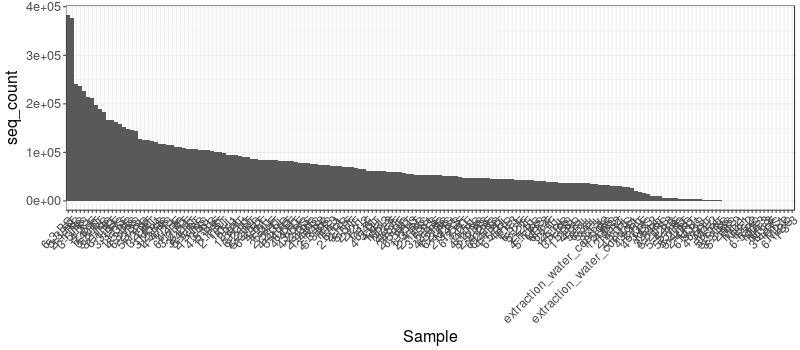

In [40]:
%%R -i df_seq_cnt -w 800 -h 350
# plotting all

df_seq_cnt$seq_count = as.numeric(df_seq_cnt$seq_count)


df_seq_cnt = df_seq_cnt %>% 
    #mutate(H2O = grepl('_F0$', Sample)) %>%
    mutate(rank = min_rank(seq_count)) %>%
    arrange(desc(rank))

df_seq_cnt$Sample = factor(df_seq_cnt$Sample, levels=df_seq_cnt$Sample)

ggplot(df_seq_cnt, aes(Sample, seq_count)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [43]:
%%R
df_seq_cnt[df_seq_cnt$seq_count < 5000,]

    Sample seq_count rank
154 5-5-RS      4263   29
155 5-2-RT      4108   28
156 5-4-RS      3946   27
157 2-4-RT      3587   26
158   M3-1      3180   25
159 6-5-BS      3115   24
160  6-2-L      2050   23
161 4-3-RT      1971   22
162   M4-2      1748   21
163  6-5-L      1163   20
164 5-1-RT       898   19
165 5-5-BS       591   18
166 3-3-BS       563   17
167 5-2-BS       512   16
168   F1-2       451   15
169   M1-1       343   14
170   M4-1       336   13
171   F2-2       273   12
172   F5-2       258   11
173 6-5-RS       251   10
174   M3-3       238    9
175   M4-3       228    8
176   M1-3       214    7
177  6-3-F       212    6
178 3-4-RS       203    5
179   F1-1       157    4
180   M2-2       150    3
181 6-1-BS       123    2
182   F3-3       113    1
